These import statements are necessary to run this notebook. Make sure you have used pip to install mediapipe. If you haven't run a cell with the command `!pip install mediapipe`

In [29]:
bb = []
bb += [tuple((1, 2, 3, 4))]
bb

[(1, 2, 3, 4)]

In [2]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import mediapipe as mp

This is a helper function for displaying images in a numpy array / cv2 matrix format using matplotlib. 

In [3]:
def resize_and_show(image, target_ht=480, target_wt=480):
    h, w = image.shape[:2]
    if h < w:
        img = cv2.resize(image, (target_wt, math.floor(h / (w / target_wt))))
    else:
        img = cv2.resize(image, (math.floor(w / (h / target_ht)), target_ht))
    # set size
    plt.figure(figsize=(10,10))
    plt.axis("off")
    # convert color from CV2 BGR back to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

This is a sample to show that the function above works

_2cantdetect.jpg


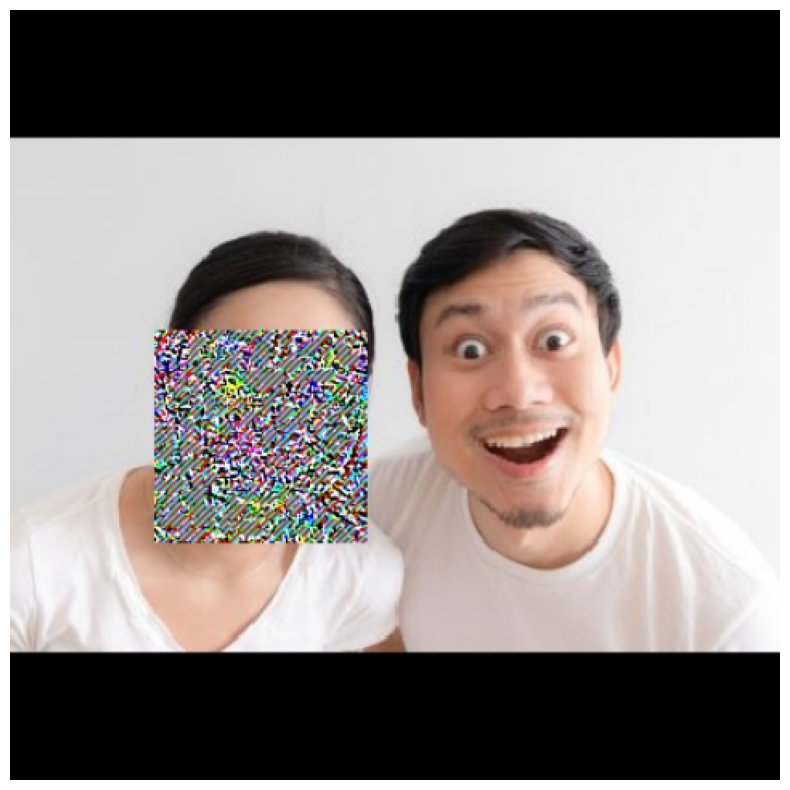

In [47]:
# Preview the images.
images = {name: cv2.imread(name) for name in ["_2cantdetect.jpg"]}
for name, image in images.items():
    print(name)   
    resize_and_show(image)

The code below is an implementation of mediapipe to show that it is working at a baseline.

Face detections of _2cantdetect.jpg:


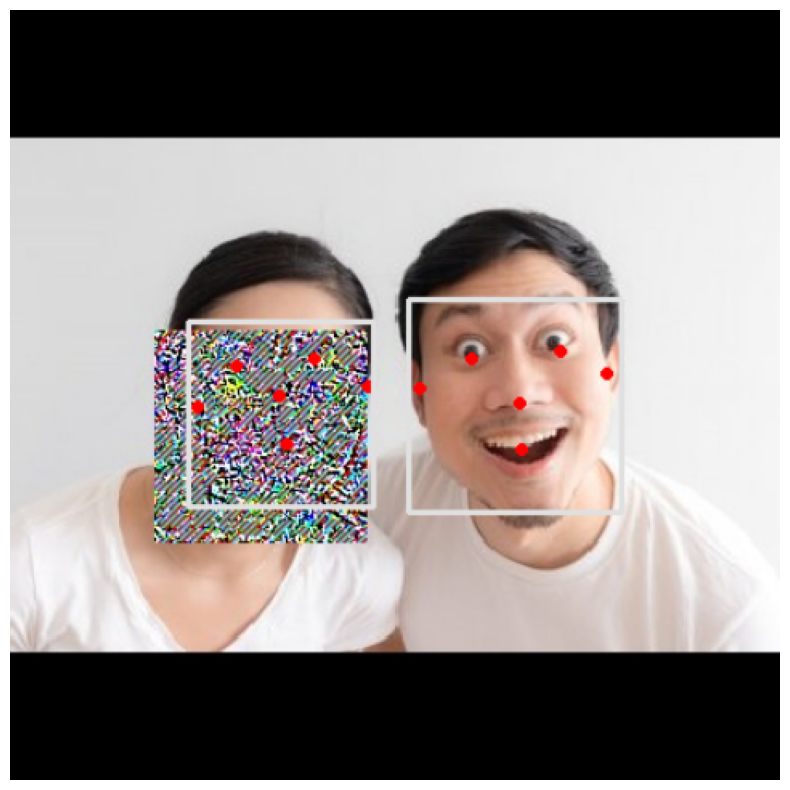

In [48]:
# Mediapipe

# Instantiate a face detector object and a drawing object from mediapipe
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# Get mediapipe face detector object
with mp_face_detection.FaceDetection(min_detection_confidence=0.5, model_selection=0) as face_detection:
    # Run mediapipe face detector on all images
    for name, image in images.items():
        # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
        results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Draw face detections of each face.
        print(f'Face detections of {name}:')
        if not results.detections:
            continue
        annotated_image = image.copy()
        for detection in results.detections:
            mp_drawing.draw_detection(annotated_image, detection)
        resize_and_show(annotated_image)

This function is to download the necessary weight of the yunet face detector

In [19]:
import os
import gdown 

def yunet_onnx():
    model_file=[
        'face_detection_yunet_2022mar.onnx'
    ]
    
    gdrive_url=[
        'https://drive.google.com/uc?id=1V7FdMzjwyGPn5QwW18D4cirzbZfKwC-i'
    ]
    
    cwd=os.getcwd() 
    if 'onnx' in os.listdir(cwd):
        for i in range(len(model_file)):
            if model_file[i] in os.listdir(os.path.join(cwd, 'onnx')):
                print(model_file[i] + ':: status : file already exists')
            else:
                gdown.download(gdrive_url[i],os.path.join(cwd, 'onnx', model_file[i]), quiet=False)
    else:
        os.makedirs(os.path.join(cwd,'onnx'))
        for i in range(len(model_file)):
            gdown.download(gdrive_url[i], os.path.join(cwd, 'onnx', model_file[i]), quiet=False)  

The code below is an implementation of yunet to show that it is working at a baseline.

face_detection_yunet_2022mar.onnx:: status : file already exists
[[221.3488     127.95573     99.64328    150.64857    245.1883
  186.78026    294.59818    181.51834    272.925      211.81454
  253.9447     235.85855    297.62143    231.49536      0.99998033]]


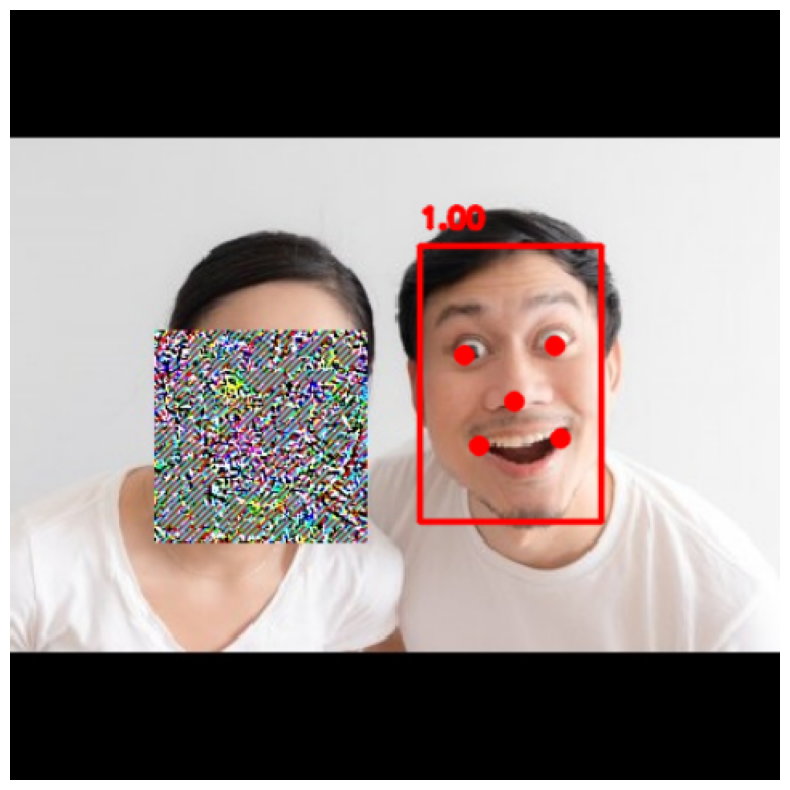

In [49]:
# Download weight if they are not available
yunet_onnx()
# Load yunet weights
yn_face_detector = cv2.FaceDetectorYN_create("onnx/face_detection_yunet_2022mar.onnx", "", (0, 0))

# Run yunet face detector on all images
for name, image in images.items():
    # Load image into YuNet face detctor
    height, width, _ = image.shape
    yn_face_detector.setInputSize((width, height))
    _, faces = yn_face_detector.detect(image)
    faces = faces if faces is not None else []
    print(faces)
    # Draw box for each face found
    for face in faces:
        box = list(map(int, face[:4]))
        color = (0, 0, 255)
        thickness = 2
        cv2.rectangle(image, box, color, thickness, cv2.LINE_AA)

        landmarks = list(map(int, face[4:len(face)-1]))
        landmarks = np.array_split(landmarks, len(landmarks) / 2)
        for landmark in landmarks:
            radius = 5
            thickness = -1
            cv2.circle(image, landmark, radius, color, thickness, cv2.LINE_AA)

        confidence = face[-1]
        confidence = "{:.2f}".format(confidence)
        position = (box[0], box[1] - 10)
        font = cv2.FONT_HERSHEY_SIMPLEX
        scale = 0.5
        thickness = 2
        cv2.putText(image, confidence, position, font, scale, color, thickness, cv2.LINE_AA)

    resize_and_show(image)

This is the original FGSM attack that uses tensors.

```
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image
```
    
For demonstration purposes it has been modified in this notebook to accept numpy arrays with value 0-255 instead as that is the format accepted by the face detectors.

In [7]:
def fgsm_attack(image, epsilon, data_grad):
    image = image / 255
    image = torch.from_numpy(image)
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad#.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    perturbed_image = perturbed_image.numpy()
    #perturbed_image = perturbed_image * 255
    return perturbed_image.astype(np.uint8)

This is the function that is used to find the minimum of a face detection model. It accepts an image and a manually defined detection function to call on the image. The return value of the detection function should be a boolean value that determines whether a face is detected on the image.

In [8]:
def min_model_eps(image, data_grad, det_fn, start = 0.1, end = 3, step = 0.05):
    # Set epsilon to the start value
    eps = start
    # Increase the epsilon value by 0.05 until it cannot be detected by the detection function or until the end
    while True:
        perturbed_img = fgsm_attack(image, eps, data_grad)
        if not det_fn(perturbed_img) or eps >= end:
            break
        else:
            eps += 0.05
    # Decrease the epsilon value by 0.01 until it can be detected by the detection function or until the start
    while True:
        perturbed_img = fgsm_attack(image, eps, data_grad)
        if det_fn(perturbed_img) or eps <= start:
            break
        else:
            eps -= 0.01
    # Add an additional 0.01 so that the returned value is the last epsilon value that the model was unable to detect
    return eps + 0.01

These manually defined detection function must do three things: 1. pre-process the image, 2. set up the face detection object, and 3. post process the output into a boolean value.

In [9]:
def mp_det_fn(image):
    with mp_face_detection.FaceDetection(min_detection_confidence=0.5, model_selection=0) as face_detection:
        results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        return results.detections is not None
    
def yn_det_fn(image):
    height, width, _ = image.shape
    yn_face_detector.setInputSize((width, height))
    _, faces = yn_face_detector.detect(image)
    return faces is not None

To try all of these together...

In [10]:
# load face image
test_img = cv2.imread("images/couple.jpg")

# Generate random guassian noise for testing
np.random.seed(42)
noise = np.random.uniform(0, 1, size=test_img.shape)

In [11]:
min_model_eps(test_img, noise, mp_det_fn)

0.11

In [12]:
min_model_eps(test_img, noise, yn_det_fn)

0.11

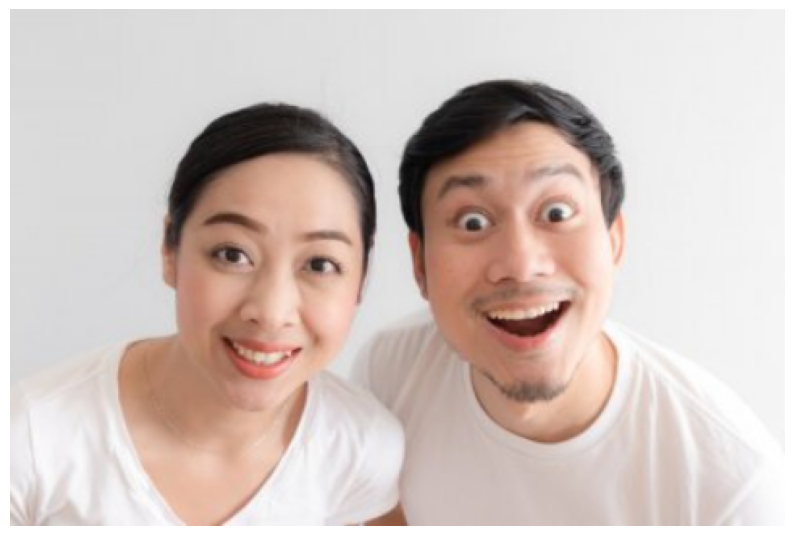

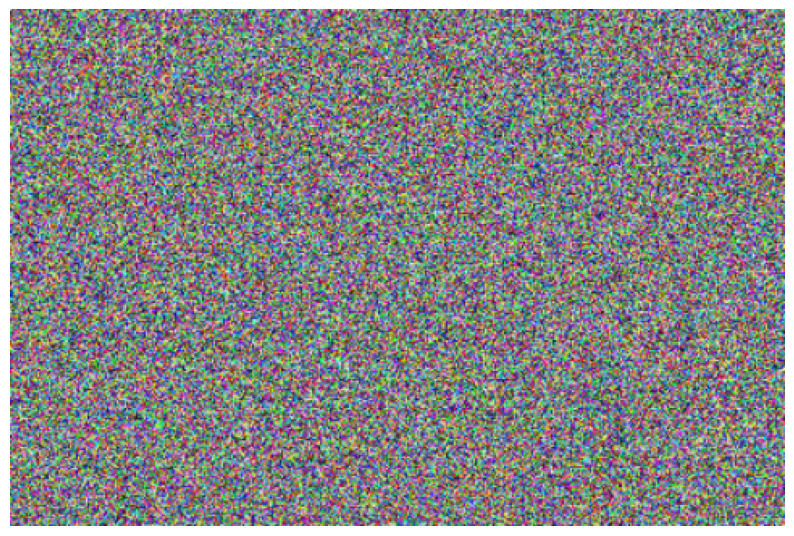

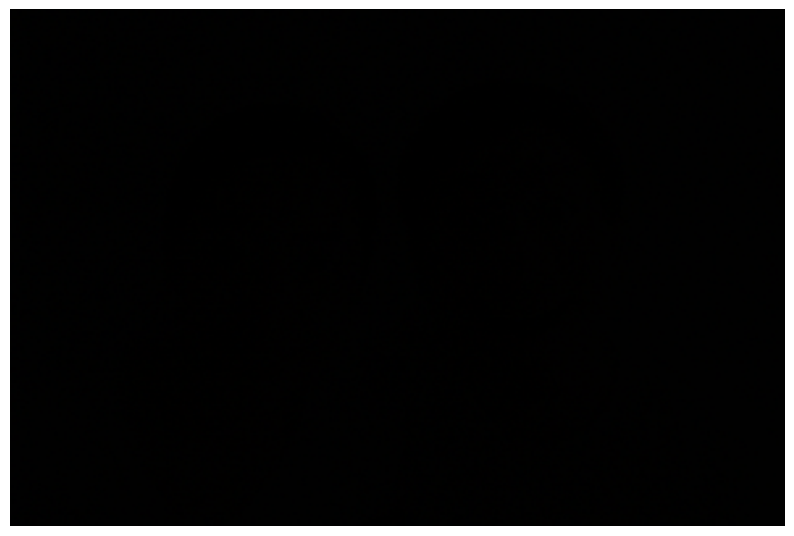

(1, None)
(1, array([[ 84.140076 ,  74.35863  ,  98.128624 , 135.74313  , 113.79535  ,
        129.87027  , 161.27615  , 134.71875  , 137.16875  , 162.24342  ,
        109.066666 , 173.91664  , 149.99135  , 178.19257  ,   0.9999834],
       [212.95558  ,  56.277077 ,  98.345055 , 144.34813  , 236.85507  ,
        110.498764 , 285.85025  , 106.799835 , 264.70065  , 135.25935  ,
        242.16199  , 158.78368  , 285.8738   , 155.88245  ,   0.9300402]],
      dtype=float32))
False
True


In [13]:
# Create a perturbed image using the guassian noise with the amount specified above
perturbed_img = fgsm_attack(test_img, 1.35, noise)

# Display the original image, the noise pattern, and the perturbed image
resize_and_show(test_img)
resize_and_show((noise * 255).astype(np.uint8))
resize_and_show(perturbed_img)

# Run the yunet face detector
height, width, _ = perturbed_img.shape
yn_face_detector.setInputSize((width, height))

# Show the result for the perturbed image vs. the original image
print(yn_face_detector.detect(perturbed_img))
print(yn_face_detector.detect(test_img))

# Check if mediapipe can detect the perturbed image using the mediapipe detection function
print(mp_det_fn(perturbed_img))
print(mp_det_fn(test_img))

___

In [14]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)